In [247]:
# PyTorch for implementing LLM (No GPU)
import torch

# Neural network modules and functions from PyTorch
from torch import nn
from torch.nn import functional as F

# NumPy for numerical operations
import numpy as np

# Matplotlib for plotting Loss etc.
from matplotlib import pyplot as plt

# Time module for tracking execution time
import time

# Pandas for data manipulation and analysis
import pandas as pd

# urllib for handling URL requests (Downloading Dataset)
import urllib.request

In [248]:
# Configuration object for model parameters
MASTER_CONFIG = {
    # Adding parameters later
}

In [249]:
# The URL of the raw text file on GitHub
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

# The file name for local storage
file_name = "tinyshakespeare.txt"

# Execute the download
urllib.request.urlretrieve(url, file_name)

('tinyshakespeare.txt', <http.client.HTTPMessage at 0x7888415fc9a0>)

In [250]:
# Read the content of the dataset
lines = open("tinyshakespeare.txt", 'r').read()

# Create a sorted list of unique characters in the dataset
vocab = sorted(list(set(lines)))

# Display the first 10 characters in the vocabulary list
print('Printing the first 10 characters of the vocab list:', vocab[:10])

# Output the total number of characters in our dataset (Vocabulary Size)
print('Total number of characters in our dataset (Vocabulary Size):', len(vocab))


Printing the first 10 characters of the vocab list: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3']
Total number of characters in our dataset (Vocabulary Size): 65


In [251]:
# Mapping integers to characters (itos)
itos = {i: ch for i, ch in enumerate(vocab)}

# Mapping characters to integers (stoi)
stoi = {ch: i for i, ch in enumerate(vocab)}

In [252]:
# Encode function: Converts a string to a list of integers using the mapping stoi
def encode(s):
    return [stoi[ch] for ch in s]

# Decode function: Converts a list of integers back to a string using the mapping itos
def decode(l):
    return ''.join([itos[i] for i in l])

# Example: Encode the string "hello" and then decode the result
decode(encode("morning"))

'morning'

In [253]:
# Convert the dataset into a torch tensor with specified data type (dtype)
dataset = torch.tensor(encode(lines), dtype=torch.int8)

# Display the shape of the resulting tensor
print(dataset.shape)

torch.Size([1115394])


In [254]:
# Function to get batches for training, validation, or testing
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    # Split the dataset into training, validation, and test sets
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    # Determine which split to use
    batch_data = train
    if split == 'val':
        batch_data = val
    if split == 'test':
        batch_data = test

    # Pick random starting points within the data
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))

    # Create input sequences (x) and corresponding target sequences (y)
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()

    return x, y

In [255]:
# Update the MASTER_CONFIG with batch_size and context_window parameters
MASTER_CONFIG.update({
    'batch_size': 8,          # Number of batches to be processed at each random split
    'context_window': 16,     # Number of characters in each input (x) and target (y) sequence of each batch
    'vocab_size': len(vocab),
})

In [256]:
# Obtain batches for training using the specified batch size and context window
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Decode the sequences to obtain the corresponding text representations
decoded_samples = [(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

# Print the random sample
print(decoded_samples)

[('uoth he: he spak', 'oth he: he spake'), ('mitted by myself', 'itted by myself!'), ("EO:\nWith love's ", "O:\nWith love's l"), ('CE:\nSaint Franci', 'E:\nSaint Francis'), (' lays it\non. She', 'lays it\non. She '), ('dness, we were a', 'ness, we were al'), (' you, take me wi', 'you, take me wit'), ("ENCE:\nAnd there'", "NCE:\nAnd there's")]


In [257]:
@torch.no_grad()  # Don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    # Placeholder for the evaluation results
    out = {}

    # Set the model to evaluation mode
    model.eval()

    # Iterate through training and validation splits
    for split in ["train", "val"]:
        # Placeholder for individual losses
        losses = []

        # Generate 10 batches for evaluation
        for _ in range(10):
            # Get input sequences (xb) and target sequences (yb)
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])

            # Perform model inference and calculate the loss
            _, loss = model(xb, yb)

            # Append the loss to the list
            losses.append(loss.item())

        # Calculate the mean loss for the split and store it in the output dictionary
        out[split] = np.mean(losses)

    # Set the model back to training mode
    model.train()

    return out


In [258]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()

        # Registering a learnable parameter 'scale' as a parameter of the module
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        """
        Assumes shape is (batch, seq_len, d_model)
        """
        # Calculating the Frobenius norm, RMS = 1/sqrt(N) * Frobenius norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5

        # Normalizing the input tensor 'x' with respect to RMS
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)

        # Scaling the normalized tensor using the learnable parameter 'scale'
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

In [259]:

# Define the SimpleModel_RMS with RMSNorm
class SimpleModel_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Embedding layer to convert character indices to vectors
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

        # RMSNorm layer for pre-normalization
        self.rms = RMSNorm((config['context_window'], config['d_model']))

        # Linear layers for modeling relationships between features
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),  # Currently using ReLU, will be replaced with SwiGLU as in LLaMA
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # Print the total number of model parameters
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        # Embedding layer converts character indices to vectors
        x = self.embedding(idx)

        # RMSNorm pre-normalization
        x = self.rms(x)

        # Linear layers for modeling relationships between features
        logits = self.linear(x)

        if targets is not None:
            # Reshape logits and targets for cross-entropy calculation
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        # If targets are not provided, return the logits
        else:
            return logits



In [260]:
# Update MASTER_CONFIG with the dimension of linear layers (128)
MASTER_CONFIG.update({
    'd_model': 128,
    'epochs': 1000,          # Number of training epochs
    'log_interval': 10,      # Log information every 10 batches during training
    'batch_size': 32,
})

# Instantiate the SimpleBrokenModel using the updated MASTER_CONFIG
model = SimpleBrokenModel(MASTER_CONFIG)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(
    model.parameters(),      # Pass the model parameters to the optimizer
)

# Print the total number of parameters in the model
print("Total number of parameters in the Simple Neural Network Model:", sum([m.numel() for m in model.parameters()]))


Model parameters: 33217
Total number of parameters in the Simple Neural Network Model: 33217


Validation loss:  2.549797296524048


<Axes: >

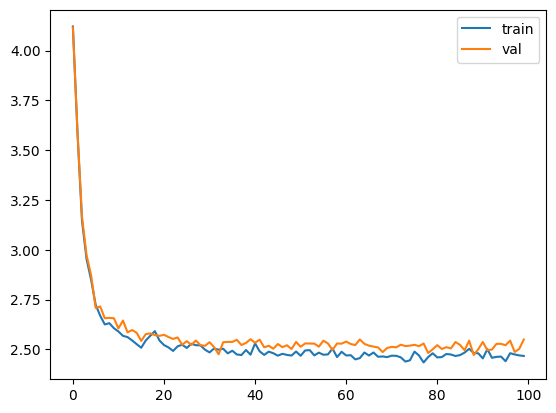

In [261]:
# Function to perform training
def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    # Placeholder for storing losses
    losses = []

    # Start tracking time
    start_time = time.time()

    # Iterate through epochs
    for epoch in range(config['epochs']):
        # Zero out gradients
        optimizer.zero_grad()

        # Obtain batches for training
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

        # Forward pass through the model to calculate logits and loss
        logits, loss = model(xs, targets=ys)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # If a learning rate scheduler is provided, adjust the learning rate
        if scheduler:
            scheduler.step()

        # Log progress every specified interval
        if epoch % config['log_interval'] == 0:
            # Calculate batch time
            batch_time = time.time() - start_time

            # Evaluate loss on validation set
            x = evaluate_loss(model)

            # Store the validation loss
            losses += [x]

            # Print progress logs if specified
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")

            # Reset the timer
            start_time = time.time()

            # Print learning rate if a scheduler is provided
            if scheduler:
                print("lr: ", scheduler.get_lr())

    # Print the final validation loss
    print("Validation loss: ", losses[-1]['val'])

    # Plot the training and validation loss curves
    return pd.DataFrame(losses).plot()

# Execute the training process
train(model, optimizer)

Model parameters: 33217
Validation loss:  2.493656778335571


<Axes: >

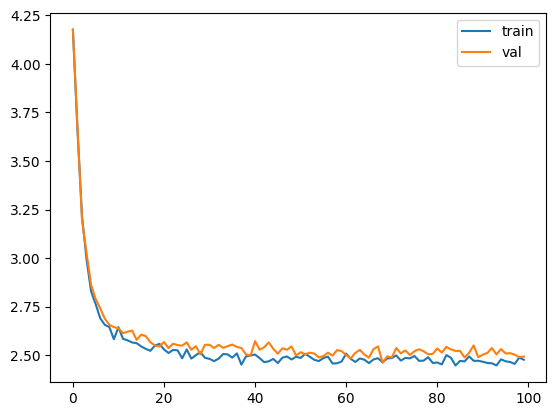

In [262]:
# Instantiate SimpleBrokenModel with MASTER_CONFIG
model = SimpleBrokenModel(MASTER_CONFIG)
# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = model(xs, ys)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters())

# Train the model
train(model, optimizer)

In [263]:
# Generate function for text generation using the trained model
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # Call the model
        logits = model(idx[:, -config['context_window']:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [decode(x) for x in idx.tolist()]

# Generate text using the trained model
generate(model)

['\nHe, ianghemet widetthe hof yop',
 '\nRWheateos a mesonoulese boerer',
 '\nHeastcaimasthanis wok Ayoucell',
 '\nGBerowair; nowshind as, gill t',
 '\n\nTh, ch:\nURKI!\nOMye, Gomern:\nD']

In [264]:
class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Linear transformation for query
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Linear transformation for key
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Linear transformation for value
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Obtain rotary matrix for positional embeddings
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        # Initialize a tensor for the rotary matrix with zeros
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)

        # Loop through each position in the context window
        for position in range(context_window):
            # Loop through each dimension in the embedding
            for i in range(embedding_dim // 2):
                # Calculate the rotation angle (theta) based on the position and embedding dimension
                theta = 10000. ** (-2. * (i - 1) / embedding_dim)
                # Calculate the rotated matrix elements using sine and cosine functions
                m_theta = position * theta
                R[position, 2 * i, 2 * i] = np.cos(m_theta)
                R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        # x: input tensor of shape (batch, sequence length, dimension)

        b, m, d = x.shape  # batch size, sequence length, dimension

        # Linear transformations for Q, K, and V
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        # Rotate Q and K using the RoPE matrix
        q_rotated = (torch.bmm(q.transpose(0, 1), self.R[:m])).transpose(0, 1)
        k_rotated = (torch.bmm(k.transpose(0, 1), self.R[:m])).transpose(0, 1)

        # Perform scaled dot-product attention
        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True
        )

        if return_attn_weights:
            # Create a causal attention mask
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0)
            # Calculate attention weights and add causal mask
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights

        return activations

In [272]:
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Create a list of RoPEMaskedAttentionHead instances as attention heads
        self.heads = nn.ModuleList([
            RoPEMaskedAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])  # Linear layer after concatenating heads
        self.dropout = nn.Dropout(0.1)  # Dropout layer

    def forward(self, x):
        # x: input tensor of shape (batch, sequence length, dimension)

        # Process each attention head and concatenate the results
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)

        # Apply linear transformation to the concatenated output
        x = self.linear(x)

        # Apply dropout
        x = self.dropout(x)
        return x


Validation loss:  2.4887458801269533


<Axes: >

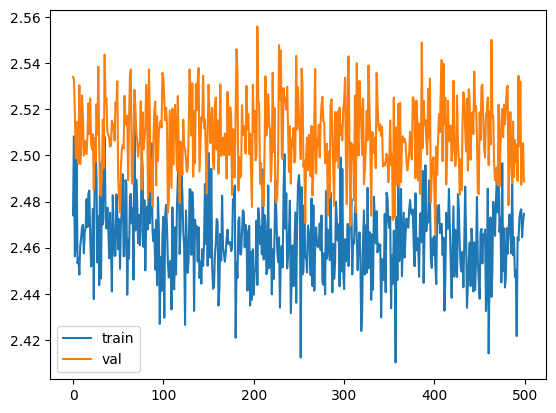

In [267]:
# Updating training configuration with more epochs and a logging interval
MASTER_CONFIG.update({
    'n_heads': 8,
    "epochs": 5000,
    "log_interval": 10,
})

# Training the model with the updated configuration
train(model, optimizer)

In [271]:
class SwiGLU(nn.Module):
    """ Paper Link -> https://arxiv.org/pdf/2002.05202v1.pdf """
    def __init__(self, size):
        super().__init__()
        self.linear_gate = nn.Linear(size, size)  # Linear transformation for the gating mechanism
        self.linear = nn.Linear(size, size)  # Linear transformation for the main branch
        self.beta = nn.Parameter(torch.ones(1))  # Learnable parameter for scaling the gating mechanism

    def forward(self, x):
        # Swish-Gated Linear Unit computation
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)  # Element-wise multiplication of the gate and main branch
        return out


In [273]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Embedding layer for input tokens
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

        # RMSNorm layer for pre-normalization
        self.rms = RMSNorm((config['context_window'], config['d_model']))

        # Multi-head attention layer with RoPE (Rotary Positional Embeddings)
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        # Linear layer followed by SwiGLU activation
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),  # Adding SwiGLU activation
        )

        # Output linear layer
        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        # Printing total model parameters
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # One block of attention
        x = self.rms(x)  # RMS pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x)  # RMS pre-normalization
        x = x + self.linear(x)  # Applying SwiGLU activation

        logits = self.last_linear(x)

        if targets is not None:
            # Calculate cross-entropy loss if targets are provided
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model params: 592706
Validation loss:  1.8964207410812377


<Axes: >

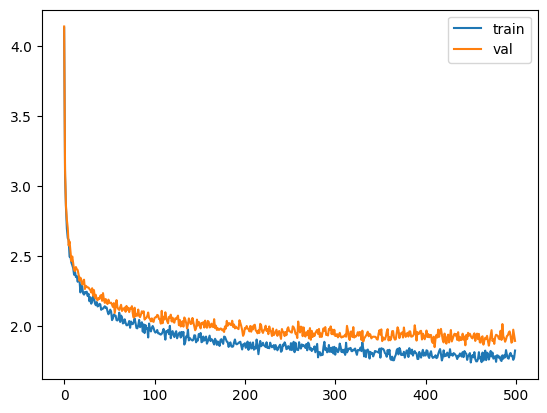

In [274]:
# Create an instance of RopeModel (RMSNorm, RoPE, Multi-Head, SwiGLU)
model = RopeModel(MASTER_CONFIG)

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = model(xs, ys)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters())

# Train the model
train(model, optimizer)

In [275]:
# Update model configurations for the number of layers
MASTER_CONFIG.update({
    'n_layers': 4,  # Set the number of layers to 4
})

In [276]:
# add RMSNorm and residual connection
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # RMSNorm layer
        self.rms = RMSNorm((config['context_window'], config['d_model']))

        # RoPE Masked Multihead Attention layer
        self.attention = RoPEMaskedMultiheadAttention(config)

        # Feedforward layer with SwiGLU activation
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        # one block of attention
        x = self.rms(x) # RMS pre-normalization
        x = x + self.attention(x)  # residual connection

        x = self.rms(x) # RMS pre-normalization
        x = x + self.feedforward(x)  # residual connection
        return x

In [277]:
# Create an instance of the LlamaBlock class with the provided configuration
block = LlamaBlock(MASTER_CONFIG)

# Generate a random tensor with the specified batch size, context window, and model dimension
random_input = torch.randn(MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model'])

# Apply the LlamaBlock to the random input tensor
output = block(random_input)

In [278]:
class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Embedding layer for token representations
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        # Sequential block of LlamaBlocks based on the specified number of layers
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )
        # Feedforward network (FFN) for final output
        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # Print total number of parameters in the model
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        # Input token indices are passed through the embedding layer
        x = self.embeddings(idx)
        # Process the input through the LlamaBlocks
        x = self.llama_blocks(x)
        # Pass the processed input through the final FFN for output logits
        logits = self.ffn(x)

        # If targets are not provided, return only the logits
        if targets is None:
            return logits
        # If targets are provided, compute and return the cross-entropy loss
        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

In [280]:
from collections import OrderedDict


model params: 2370246
Validation loss:  1.5470302820205688


<Axes: >

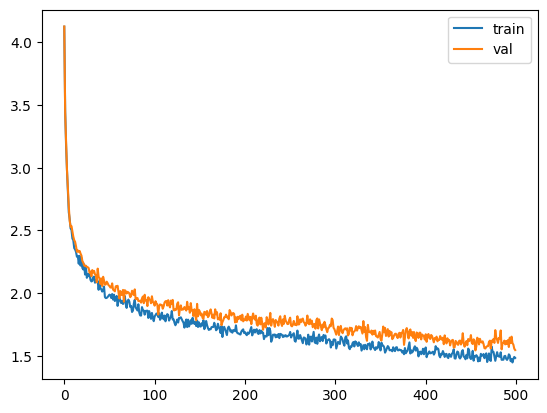

In [281]:
# Create an instance of RopeModel (RMSNorm, RoPE, Multi-Head, SwiGLU, N_layers)
llama = Llama(MASTER_CONFIG)

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = llama(xs, ys)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(llama.parameters())

# Train the model
train(llama, optimizer)

Validation loss:  1.2012680888175964


<Axes: >

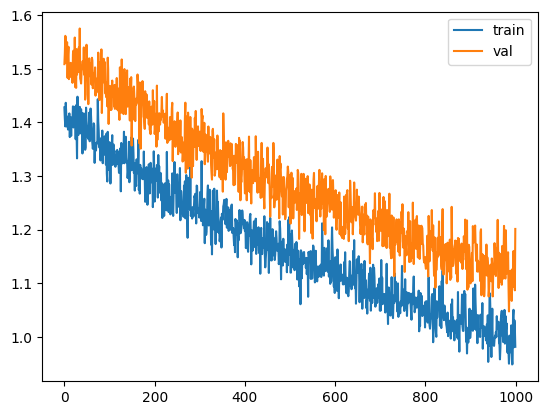

In [287]:
# Update the number of epochs in the configuration
MASTER_CONFIG.update({
    'epochs': 10000,
})
# Train the LLaMA model for the specified number of epochs
train(llama, optimizer, scheduler=None, config=MASTER_CONFIG)

Validation loss:  1.533138680458069


<Axes: >

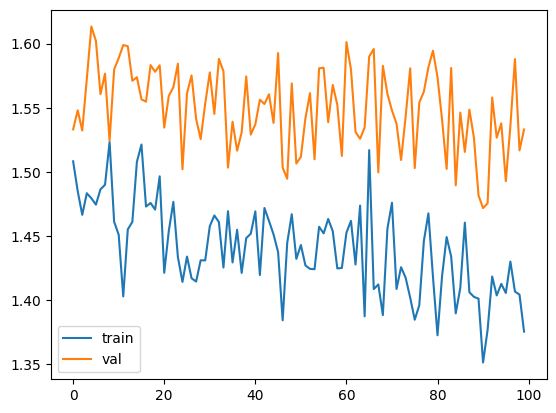

In [286]:
# Training the model again, scheduler for better optimization.
train(llama, optimizer, config=MASTER_CONFIG)

In [285]:
# Generate text using the trained LLM (llama) with a maximum of 500 tokens
generated_text = generate(llama, MASTER_CONFIG, 500)[0]
print(generated_text)



COMINDIUS:
Do, I lasir.

LADYS, away, lundmed-tilling,
Asfed dutidous,
Poy, to a'intiginnelm-st a ose a tolk's allour, aftek'll. I lis sall to if on thiol meo noft, orst,
Ad Xall'chard,
Thelfiedsioss so oenesom 'eign
dones at thou man: meach.

What 'did be'hal titure our
wiscurlais
Till, tter mai, away, mad witcal.

Dure,
I liee ber'ay men's roReasur's Yonk of near -keeped and love Mleapted; our me.

entrand?

Thoue no it bury are
In nots in Tonlisus, no mup mity?

Ro a barese but her me:
In :



In [284]:
# Get batches from the test set
xs, ys = get_batches(dataset, 'test', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Pass the test data through the LLaMA model
logits, loss = llama(xs, ys)

# Print the loss on the test set
print(loss)

tensor(1.7917, grad_fn=<NllLossBackward0>)


model params: 2370246


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:854: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


lr:  [0.0009999457184159408]
lr:  [0.0009961510274583004]
lr:  [0.0009869757772816292]
lr:  [0.0009725204933511963]
lr:  [0.0009529435502760634]
lr:  [0.0009284594366176498]
lr:  [0.0008993364049014041]
lr:  [0.0008658935325782156]
lr:  [0.0008284972261358946]
lr:  [0.0007875572066618724]
lr:  [0.0007435220208394261]
lr:  [0.0006968741265588948]
lr:  [0.0006481246069855613]
lr:  [0.0005978075709959357]
lr:  [0.0005464743013294258]
lr:  [0.0004946872145648923]
lr:  [0.00044301369909075325]
lr:  [0.00039201989856974814]
lr:  [0.0003422645089892466]
lr:  [0.0002942926572257539]
lr:  [0.0002486299281339155]
lr:  [0.0002057766054928797]
lr:  [0.00016620218969383484]
lr:  [0.00013034025177986015]
lr:  [9.85836791664324e-05]
lr:  [7.128036241775617e-05]
lr:  [4.872936226262451e-05]
lr:  [3.117756953567661e-05]
lr:  [1.8816750064937722e-05]
lr:  [1.1779739336260682e-05]
lr:  [1.0054282328142978e-05]
lr:  [1.396862020283371e-05]
lr:  [2.3138198807489664e-05]
lr:  [3.7591595433673565e-05]
lr:  [

<Axes: >

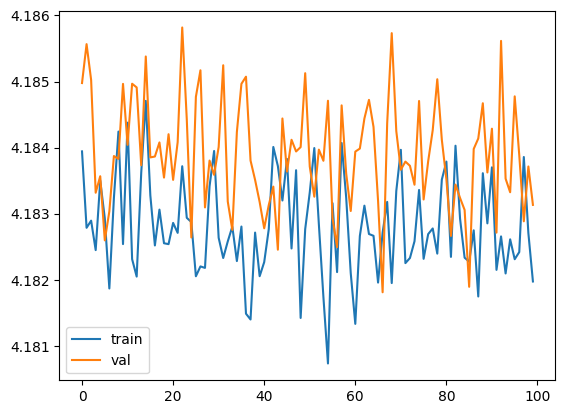

In [283]:
# Update configuration
MASTER_CONFIG.update({
    "epochs": 1000
})

# Create Llama model with Cosine Annealing learning schedule
llama_with_cosine = Llama(MASTER_CONFIG)

# Define Adam optimizer with specific hyperparameters
llama_optimizer = torch.optim.Adam(
    llama.parameters(),
    betas=(.9, .95),
    weight_decay=.1,
    eps=1e-9,
    lr=1e-3
)

# Define Cosine Annealing learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(llama_optimizer, 300, eta_min=1e-5)

# Train the Llama model with the specified optimizer and scheduler
train(llama_with_cosine, llama_optimizer, scheduler=scheduler)

In [289]:
# Save the entire model
torch.save(llama, 'llama_model.2.pth')